In [4]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import os
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns

def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    
    
# specify the directory where data are stored
DATADIR = ''

# specify the directory where data and metadata are stored
METADATADIR = '../../input/'

In [5]:
# load data
adatareduced = ad.read('processed_Cusanovich2018_subset.h5ad')

### metrics

In [ ]:
# metrics on the default louvain clustering

labels_true = adatareduced.obs['label']
labels_pred = adatareduced.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

step 0
got 23 at resolution 1.5
step 1
got 17 at resolution 0.75
step 2
got 14 at resolution 0.375
step 3
got 12 at resolution 0.1875
step 4
got 13 at resolution 0.28125


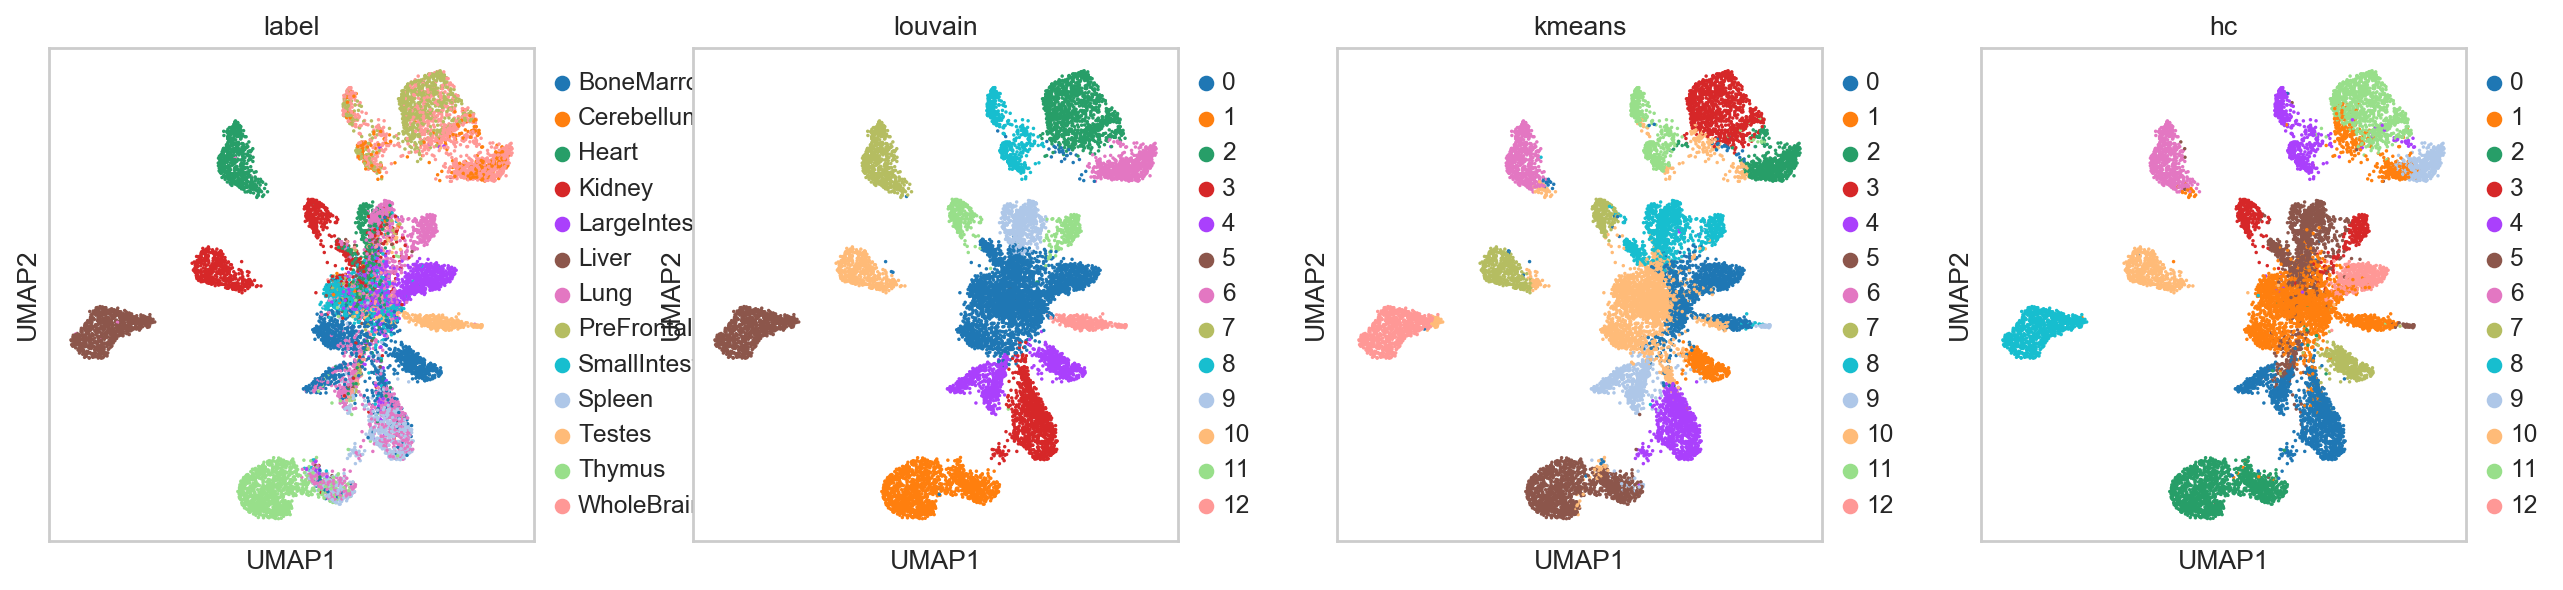

In [43]:
############ Benchmarking ############
    
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])


# set method name
method = 'epiScanpy-adata'

# convert the cell label to standard label
#adata.obs['label'] = adata.obs['cell_type']

# set the number of cluster for louvain
num_clusters = len(np.unique(adatareduced.obs['label']))
#print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adatareduced,n_cluster=num_clusters)

#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['kmeans'] = pd.Series(kmeans.labels_,index=adatareduced.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
ari_kmeans = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
ari_hc = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
homo_kmeans = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
homo_hc = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adatareduced, color=['label', 'louvain', 'kmeans', 'hc'])


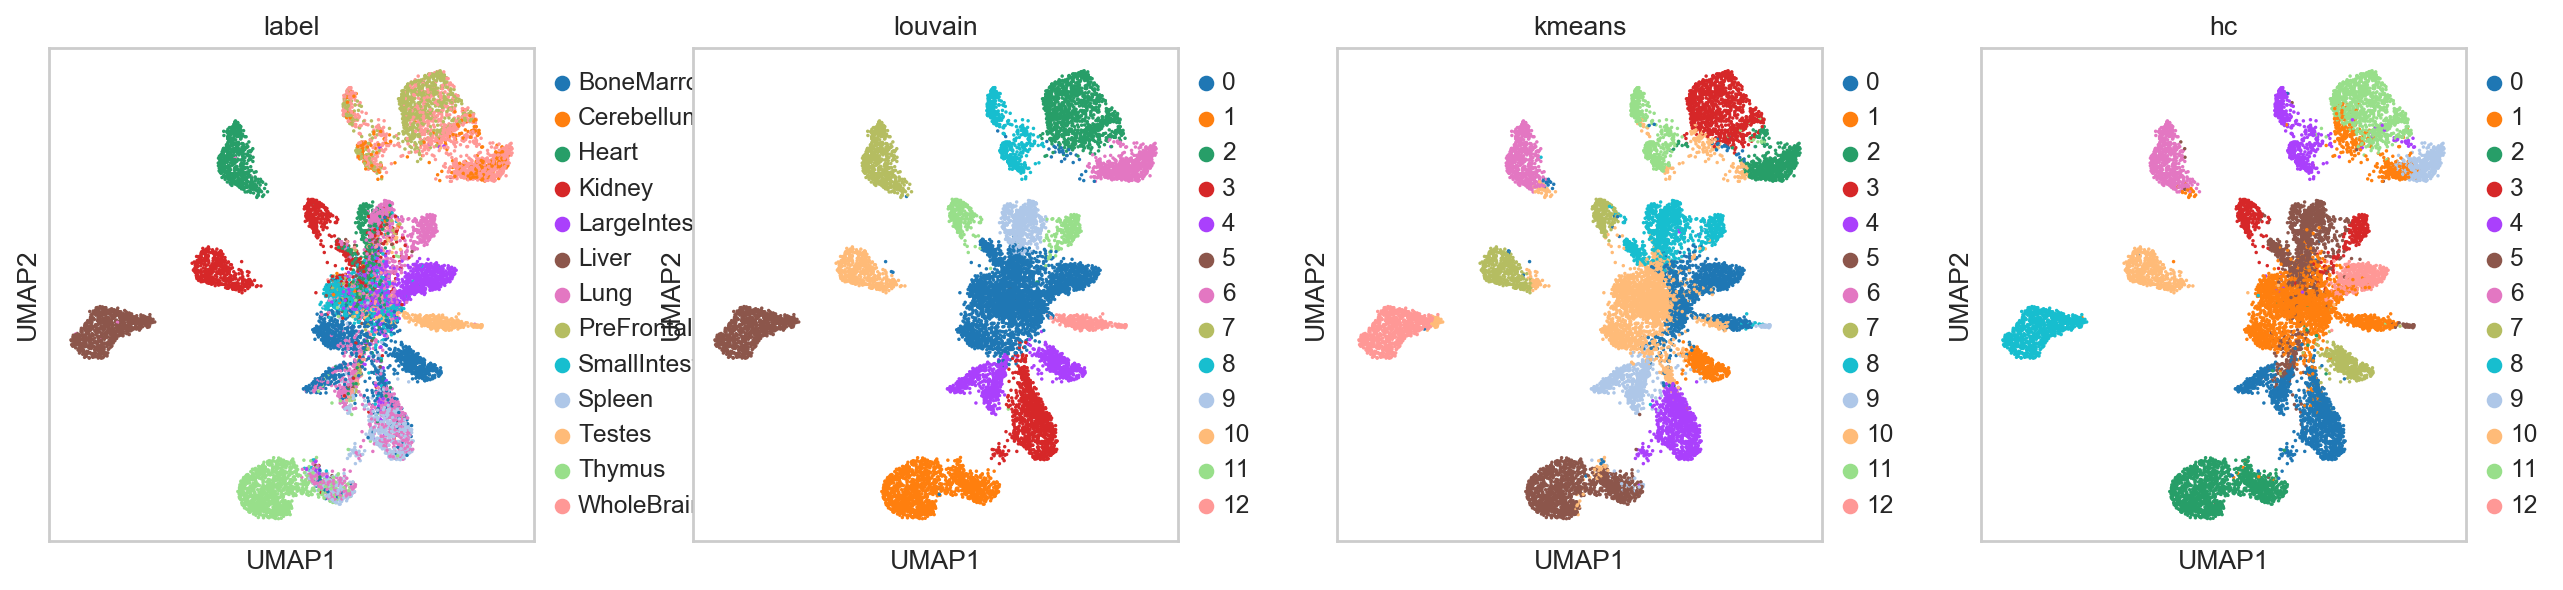

,ARI_Louvain,ARI_kmeans,ARI_HC,AMI_Louvain,AMI_kmeans,AMI_HC,Homogeneity_Louvain,Homogeneity_kmeans,Homogeneity_HC,method
epiScanpy-adata,0.332421,0.324030,0.303018,0.573688,0.533831,0.542027,0.556378,0.526960,0.529398,epiScanpy-adata
ChromVAR_kmers,0.362156,0.318281,0.322602,0.547156,0.508931,0.505412,0.529241,0.494062,0.499065,ChromVAR_kmers
ChromVAR_motifs,0.273587,0.234159,0.232830,0.467077,0.381515,0.389418,0.452938,0.378984,0.374202,ChromVAR_motifs
cisTopic,0.326831,0.311433,0.334379,0.594191,0.548624,0.584576,0.562274,0.528385,0.572242,cisTopic
SnapATAC,0.311580,0.315666,0.238986,0.583190,0.538058,0.570649,0.549473,0.526652,0.526307,SnapATAC
SCRAT_motifs,0.150932,0.077564,0.076397,0.299833,0.175588,0.174113,0.301070,0.177310,0.174480,SCRAT_motifs
BROCKMAN,0.229773,0.108314,0.095058,0.402846,0.245153,0.216923,0.403183,0.246948,0.218872,BROCKMAN
Cusanovich2018,0.314571,0.312622,0.394549,0.588781,0.532839,0.579267,0.562294,0.520058,0.575403,Cusanovich2018
Control,0.332837,0.031021,0.032305,0.548613,0.176790,0.183920,0.540980,0.145575,0.146171,Control
GeneScoring,0.074074,0.018880,0.030184,0.159352,0.115906,0.178871,0.151916,0.095670,0.143932,GeneScoring


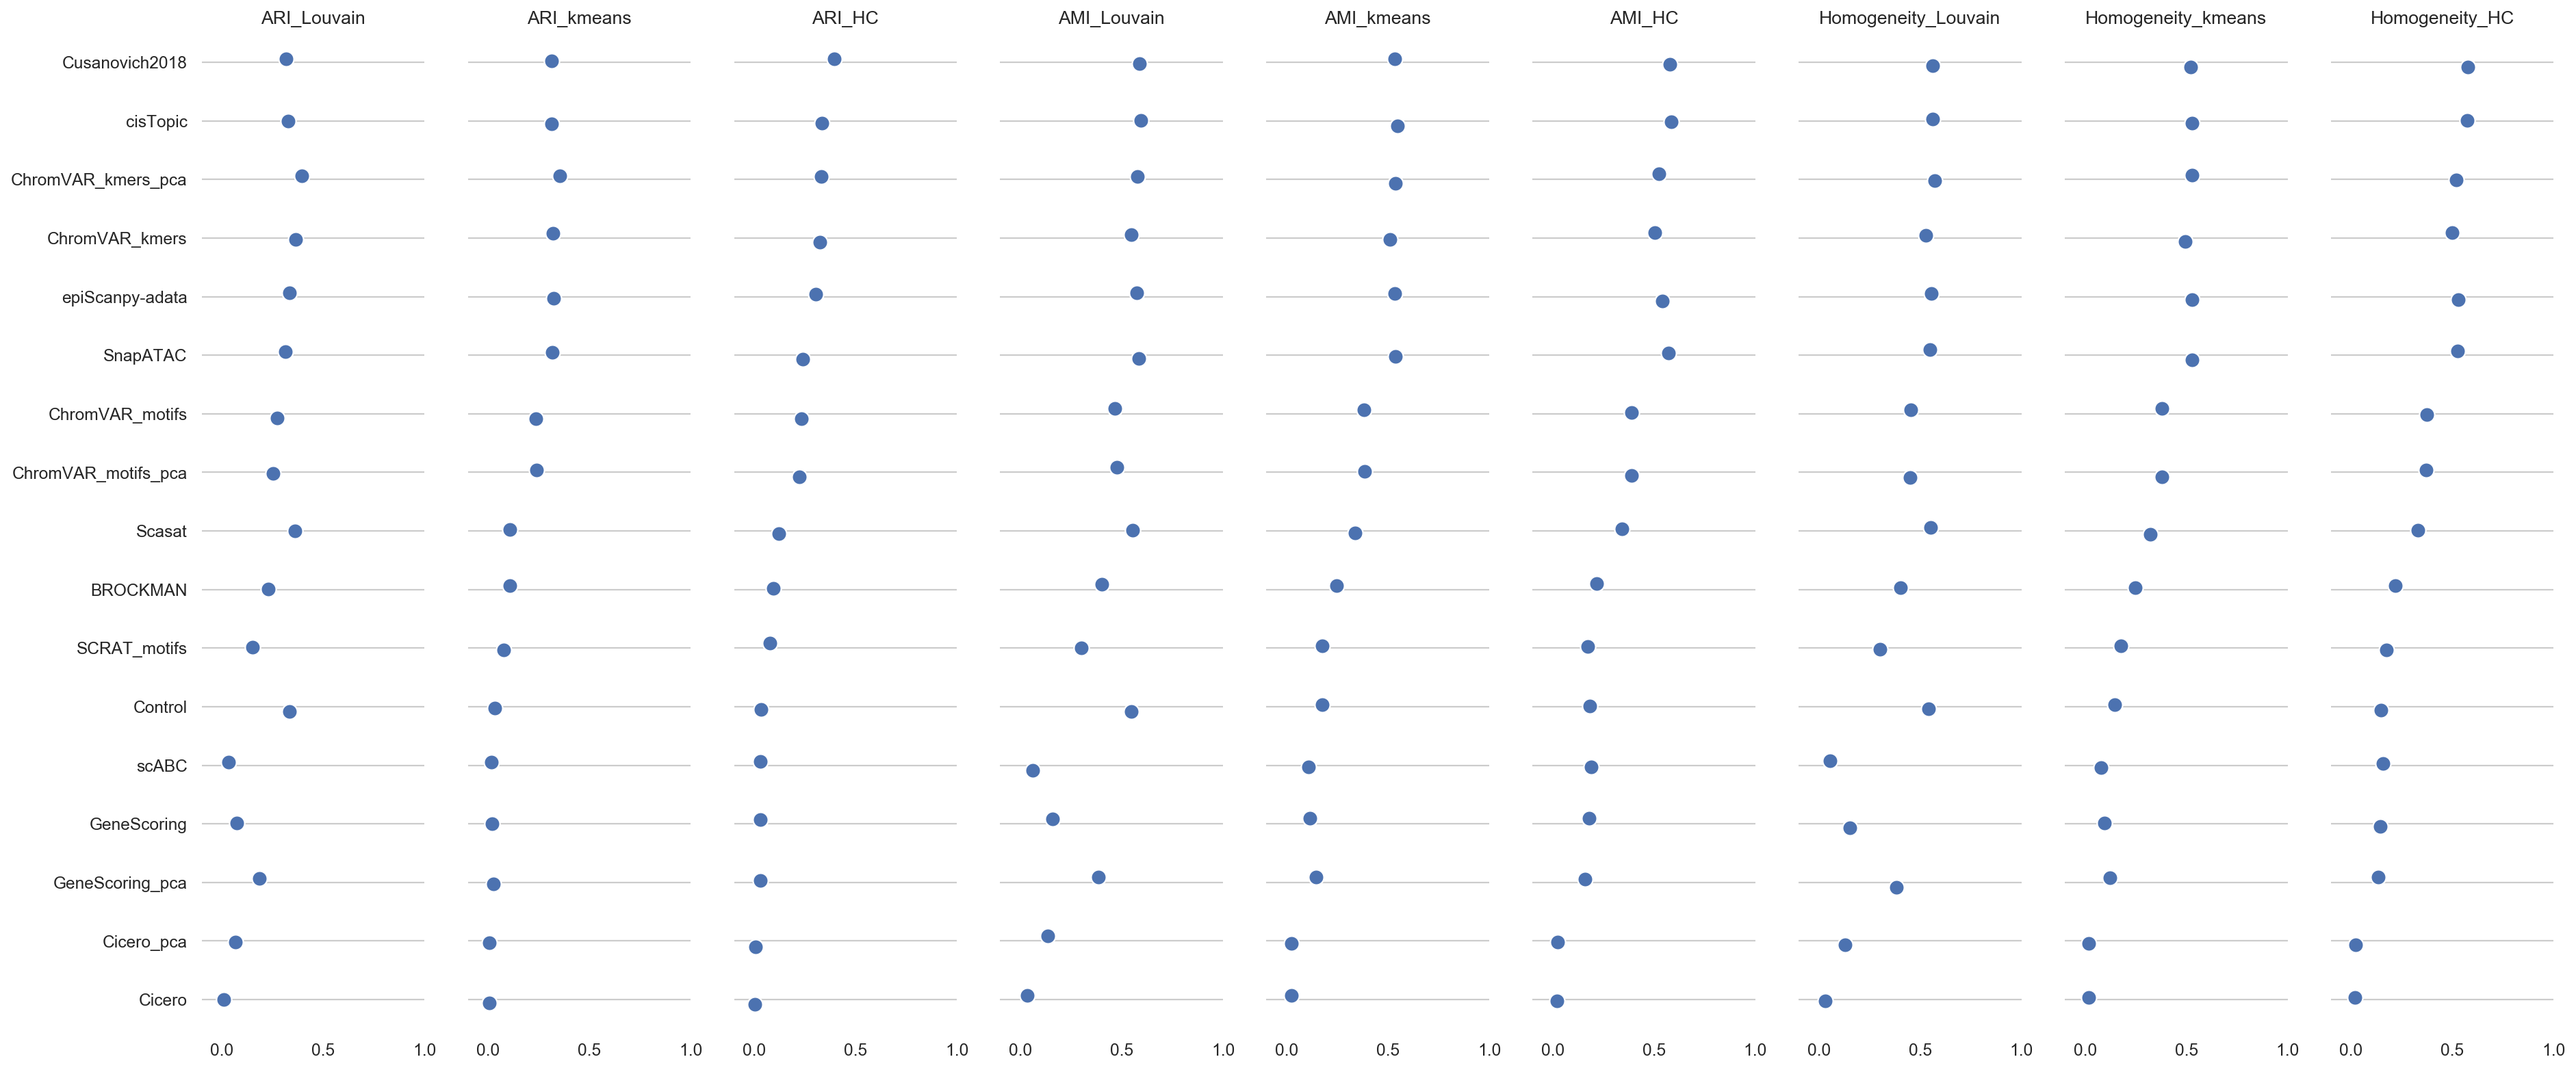

In [45]:
all_metrics = """ChromVAR_kmers	0.362156	0.318281	0.322602	0.547156	0.508931	0.505412	0.529241	0.494062	0.499065
ChromVAR_motifs	0.273587	0.234159	0.23283	0.467077	0.381515	0.389418	0.452938	0.378984	0.374202
cisTopic	0.326831	0.311433	0.334379	0.594191	0.548624	0.584576	0.562274	0.528385	0.572242
SnapATAC	0.31158	0.315666	0.238986	0.58319	0.538058	0.570649	0.549473	0.526652	0.526307
SCRAT_motifs	0.150932	0.077564	0.076397	0.299833	0.175588	0.174113	0.30107	0.17731	0.17448
BROCKMAN	0.229773	0.108314	0.0950577	0.402846	0.245153	0.216923	0.403183	0.246948	0.218872
Cusanovich2018	0.314571	0.312622	0.394549	0.588781	0.532839	0.579267	0.562294	0.520058	0.575403
Control	0.332837	0.0310206	0.0323049	0.548613	0.17679	0.18392	0.54098	0.145575	0.146171
GeneScoring	0.0740742	0.01888	0.0301842	0.159352	0.115906	0.178871	0.151916	0.0956696	0.143932
Scasat	0.358806	0.107472	0.121207	0.554397	0.33932	0.343008	0.552355	0.32181	0.327857
scABC	0.0331424	0.0164305	0.0304001	0.059114	0.107217	0.191117	0.0560104	0.0794209	0.15644
Cicero	0.00946335	0.00507737	0.00337704	0.0332948	0.0234078	0.0210244	0.0312832	0.0191649	0.0168756
ChromVAR_kmers_pca	0.393402	0.353105	0.330552	0.57713	0.537296	0.523283	0.570369	0.529479	0.519517
ChromVAR_motifs_pca	0.252594	0.237495	0.222042	0.475341	0.383546	0.387681	0.449016	0.380229	0.371064
GeneScoring_pca	0.184099	0.0265249	0.0295811	0.384399	0.143917	0.15945	0.38142	0.121941	0.132441
Cicero_pca	0.0675771	0.00516015	0.00720392	0.133417	0.0235267	0.025529	0.129841	0.0192896	0.0213231
SCRAT_pca	0.153423	0.0777187	0.0852386	0.286294	0.176089	0.181604	0.289815	0.177849	0.183358"""



all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics:
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

sc.pl.umap(adatareduced, color=['label', 'louvain', 'kmeans', 'hc'])


for key in df_metrics.keys():
    df_metrics[key] = [float(key) for key in df_metrics[key]]
    
df_metrics['method'] = df_metrics.index.tolist()


sns.set(style="whitegrid")

# data to plot
df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values("ARI_HC",
                                        ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

df_metrics